# SENG 474 A02: Assignment 3
## Lloyd's Algorithm and Hierarchical Agglomerative Clustering
Sean McAuliffe, V00913346  
March 23, 2023


(3500, 2)
(14801, 3)


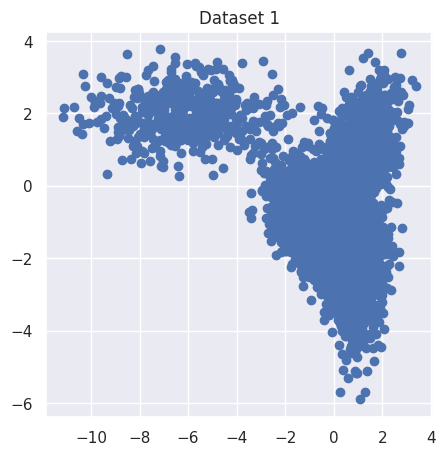

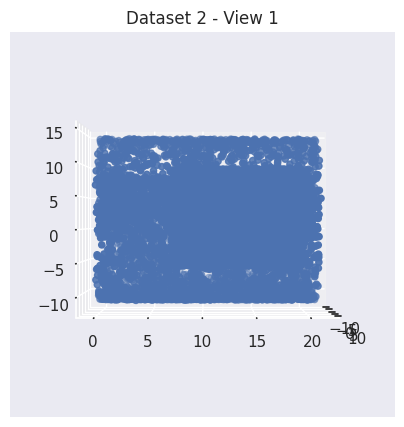

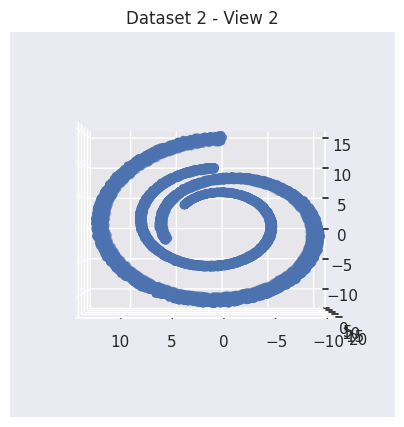

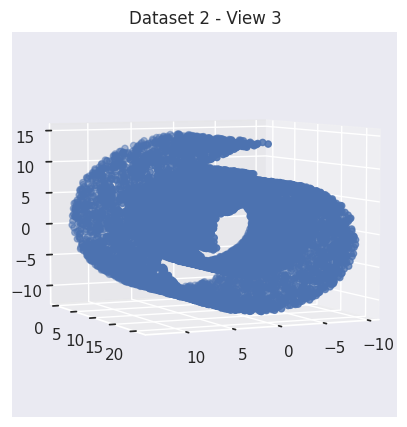

In [29]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

# Load data
dataset_1 = np.loadtxt('../data/dataset1.csv', delimiter=',')
dataset_2 = np.loadtxt('../data/dataset2.csv', delimiter=',')

print(dataset_1.shape)
print(dataset_2.shape)

# Visualize the datasets
x_1 = dataset_1[:, 0]
y_1 = dataset_1[:, 1]

x_2 = dataset_2[:, 0]
y_2 = dataset_2[:, 1]
z_2 = dataset_2[:, 2]

plt.figure(figsize=(5,5))
plt.scatter(x_1, y_1)
plt.title('Dataset 1')

fig2 = plt.figure(figsize=(5,5))
ax1 = fig2.add_subplot(111, projection='3d')
ax1.scatter(x_2, y_2, z_2)
ax1.view_init(elev=0, azim=0)
plt.title('Dataset 2 - View 1')

fig3 = plt.figure(figsize=(5,5))
ax2 = fig3.add_subplot(111, projection='3d')
ax2.scatter(x_2, y_2, z_2)
ax2.view_init(elev=0, azim=90)
plt.title('Dataset 2 - View 2')

fig4 = plt.figure(figsize=(5,5))
ax3 = fig4.add_subplot(111, projection='3d')
ax3.scatter(x_2, y_2, z_2)
ax3.view_init(elev=5, azim=65)
plt.title('Dataset 2 - View 3')

plt.show()

## Part 1: Lloyd's Algorithm
- Implement Lloyd's Algorithm for k-means clustering
- Two initialization methods:
    - Uniform Random Initialization, where each point has the same probability of
    being chosen as a cluster centre.
    - K-means++ Initialization, where the first cluster centre is chosen uniformly
    at random from the data points, and each subsequent cluster centre is chosen
    with probability proportional to the squared distance from the nearest
    cluster centre.

In [44]:
def euclidean_distance(x1, x2):
    """ Euclidian distance """
    return np.sqrt(np.sum((x1 - x2)**2))

class Cluster:
    def __init__(self, centre):
        self.data = [] # includes the centre point
        self.centre = centre

    def add(self, point):
        self.data.append(point)

    def distance(self, point):
        """ Squared Euclidean distance """
        return np.sum((self.centre - point)**2)
    
    def cost(self):
        """ Sum of squared distances from centre """
        cost = 0
        for point in self.data:
            cost += self.distance(point)
        return cost
    
    def clear_data(self):
        self.data = []
    
    def __str__(self):
        return 'Cluster: centre = {}'.format(self.centre)

def total_cost(clusters):
    cost = 0
    for cluster in clusters:
        cost += cluster.cost()
    return cost

def float_equal(a, b):
    return abs(a - b) < 0.00001

def get_centres(clusters):
    """ Return a list of the cluster centres """
    return [c.centre for c in clusters]
    
def is_unique(centres, centre):
    """ Check that a cluster centre has not already been chosen """
    for c in centres:
        if c[0] == centre[0] and c[1] == centre[1]:
            return False
    return True

def all_centres_equal(previous, new):
    """ Check that the cluster centres have not changed """
    for i in range(len(previous)):
        if not float_equal(previous[i][0],new[i][0]) or not float_equal(previous[i][1], new[i][1]):
            return False
    return True

# Uniform Random Initialization, define k clusters with random centres
def init_random(X, k):
    clusters = []
    centres = []
    for i in range(k):
        # Ensure that the centres are unique
        for c in clusters:
            centres.append(c.centre)
        # Randomly choose a centre
        centre = X[np.random.randint(0, len(X))]
        while not is_unique(centres, centre):
            centre = X[np.random.randint(0, len(X))]
        centres.append(centre)
        clusters.append(Cluster(centre))
    return clusters

# K-Means++ Initialization, define k clusters with centres chosen
# with probability proportional to distance to existing clusters
def init_kmeans(X, k):
    clusters = []
    centres = []
    # Randomly choose the first centre
    centre = X[np.random.randint(0, len(X))]
    clusters.append(Cluster(centre))
    centres.append(centre)
    # Choose the remaining centres
    for i in range(1, k):
        # Compute the distance from each point to its closest centre
        # dists[0] = distance from X[0] to its closest centre
        dists = []
        for x in X:
            min_dist = np.inf
            for cluster in clusters:
                dist = cluster.distance(x)
                if dist < min_dist:
                    min_dist = dist
            dists.append(min_dist)
        # Choose the next centre with probability proportional to distance
        probability_vector = dists/np.sum(dists)
        centre = X[np.random.choice(len(X), p=probability_vector)]
        # Ensure that the centres are unique
        while not is_unique(centres, centre):
            centre = X[np.random.choice(len(X), p=probability_vector)]
        centres.append(centre)
        clusters.append(Cluster(centre))
    return clusters

# # Assign each data point to the cluster with the closest centre
def assign_to_closest(X, clusters):
    for x in X:
        min_dist = np.inf
        min_cluster = None
        for cluster in clusters:
            dist = cluster.distance(x)
            if dist < min_dist:
                min_dist = dist
                min_cluster = cluster
        min_cluster.add(x)

def lloyd(X, k, init):
    # Initialize the clusters
    C = init(X, k)
    # Repeat until the centres do not change
    previous_centres = get_centres(C)
    i = 0
    while True:
        i += 1
        # Assign each data point to the cluster with the closest centre
        for cluster in C:
            cluster.clear_data()
        assign_to_closest(X, C)
        # Update the cluster centres
        for cluster in C:
            ideal_centre = np.mean(cluster.data, axis=0)
            # Find the point in the data closest to the idealized centre
            min_dist = np.inf
            min_point = None
            for point in cluster.data:
                dist = euclidean_distance(point, ideal_centre)
                if dist < min_dist:
                    min_dist = dist
                    min_point = point
            cluster.centre = deepcopy(min_point)
        # Check if the centres have changed
        new_centres = get_centres(C)
        if all_centres_equal(previous_centres, new_centres):
            break
        previous_centres = new_centres
    return i, C

def plot_clusters_2d(clusters):
    colours = ['b', 'g']
    for i, cluster in enumerate(clusters):
        x = [p[0] for p in cluster.data]
        y = [p[1] for p in cluster.data]
        plt.scatter(x, y, alpha=0.3, c=colours[i])
        plt.scatter(cluster.centre[0], cluster.centre[1], c='black', marker='x')
    plt.show()

Random: Number of iterations: 8


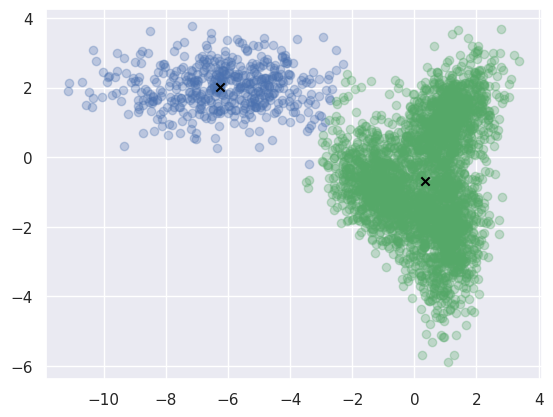

Kmeans: Number of iterations: 11


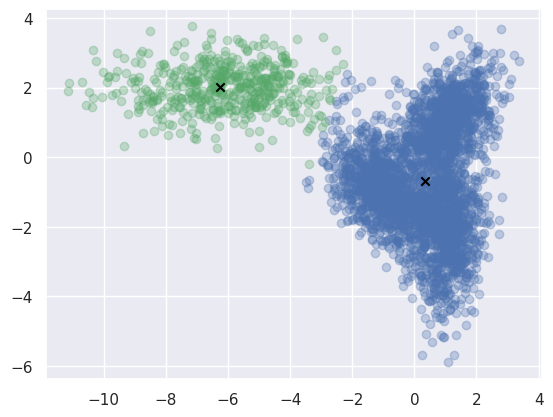

Random: Number of iterations: 5


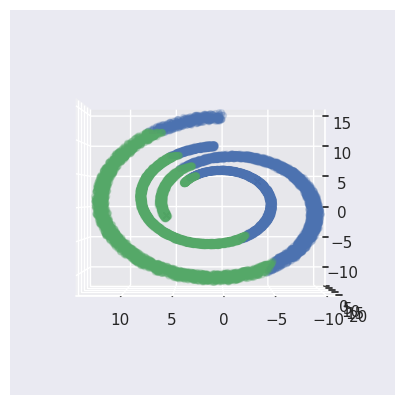

Kmeans: Number of iterations: 4


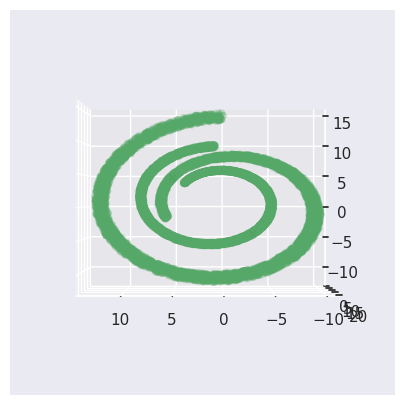

In [47]:
# Sanity Test of the Lloyd Algorithm
i, C = lloyd(dataset_1, 2, init_random)
print('Random: Number of iterations: {}'.format(i))
plot_clusters_2d(C)

i, C = lloyd(dataset_1, 2, init_kmeans)
print('Kmeans: Number of iterations: {}'.format(i))
plot_clusters_2d(C)

colours = ['b', 'g']

i, C = lloyd(dataset_2, 2, init_random)
print('Random: Number of iterations: {}'.format(i))
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
for j, cluster in enumerate(C):
    x = [p[0] for p in cluster.data]
    y = [p[1] for p in cluster.data]
    z = [p[2] for p in cluster.data]
    ax.scatter(x, y, z, alpha=0.2, c=colours[j])
    ax.view_init(elev=0, azim=90)
    ax.scatter(cluster.centre[0], cluster.centre[1], cluster.centre[2], c='black', marker='x')
plt.show()

i, C = lloyd(dataset_2, 2, init_kmeans)
print('Kmeans: Number of iterations: {}'.format(i))
fig2 = plt.figure(figsize=(5,5))
ax = fig2.add_subplot(111, projection='3d')
for cluster in C:
    x = [p[0] for p in cluster.data]
    y = [p[1] for p in cluster.data]
    z = [p[2] for p in cluster.data]
    ax.scatter(x, y, z , alpha=0.2, c=colours[j])
    ax.view_init(elev=0, azim=90)
    ax.scatter(cluster.centre[0], cluster.centre[1], cluster.centre[2], c='black', marker='x')
plt.show()

---

k = 2, cost = 6211.744016155597
k = 3, cost = 4668.349794689788
k = 4, cost = 3658.462357683589
k = 5, cost = 3350.6660739890167
k = 6, cost = 3115.910664793836
k = 7, cost = 2904.243415590368
k = 8, cost = 2666.2333650915866
k = 9, cost = 2544.127755758907
k = 10, cost = 2437.2741100980825
k = 11, cost = 2331.556353113114
k = 12, cost = 2235.259480718616
k = 13, cost = 2159.5905314861106
k = 14, cost = 2089.804087768183
k = 15, cost = 2021.4121742987932
k = 16, cost = 1965.0078820088581
k = 17, cost = 1908.0282423102228
k = 18, cost = 1856.8678089378734
k = 19, cost = 1811.4431630107977


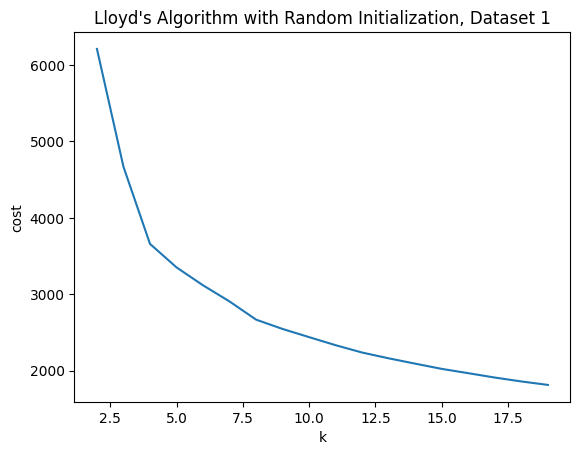

In [132]:
# Experiment 1: Lloyd's Algorithm with Random Initialization, Dataset 1

k_values = [k for k in range(2, 20)]
num_trials = 10

costs = []

for k in k_values:
    min_cost = np.inf
    chosen_clustering = None
    for i in range(num_trials):
        i, C = lloyd(dataset_1, k, init_random)
        cost = total_cost(C)
        if cost < min_cost:
            min_cost = cost
            chosen_clustering = C
    # At this point we have the best clustering for this k
    print('k = {}, cost = {}'.format(k, min_cost))
    costs.append(min_cost)

# Plot the cost as a function of k
plt.title('Lloyd\'s Algorithm with Random Initialization, Dataset 1')
plt.plot(k_values, costs)
plt.xlabel('k')
plt.ylabel('cost')
plt.show()

The cost of a clustering seems to decrease without bound as the number of clusters
is allowed to grow. This is because the cost is the sum of the squared distances
between each point and its cluster centre. As the number of clusters grows, the
distance between each point and its cluster centre will decrease. This is
demonstrated in the above plot. The time required to compute a clustering also
increases with k, in the above implementation.

The 'correct' number of clusters in Dataset 1, I would have predicted to be 2. 
However, I would argue that there are two likely candidates in the graph above,
for points of diminishing returns. The first is at k=3, where there is a sharp
elbow, and the second is at k=8, where the cost gains begins to level off.

---

k     cost       iterations
2     13563.45   10        
3     8195.58    8         
4     5121.20    6         
5     4238.09    6         
6     3534.15    8         
7     3062.63    13        
8     2614.40    11        
9     2374.03    11        
10    2214.28    15        


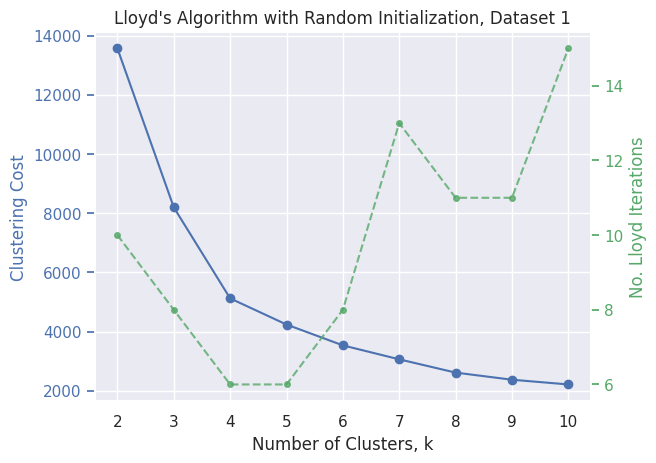

In [33]:
# Experiment 1: Lloyd's Algorithm with Random Initialization, Dataset 1

k_values = [k for k in range(2, 11)]
num_trials = 10
costs = []
iterations = []

print(f"{'k':<5} {'cost':<10} {'iterations':<10}")
for k in k_values:
    min_cost = np.inf
    C = None
    steps = 0
    for _ in range(num_trials):
        steps_, C_ = lloyd(dataset_1, k, init_random)
        cost = total_cost(C_)
        if cost < min_cost:
            steps = steps_
            min_cost = cost
            C = C_
    # At this point we have the best clustering for this k
    print(f"{k:<5} {min_cost:<10.2f} {steps:<10}")
    iterations.append(steps)
    costs.append(min_cost)

# Plot the cost as a function of k
fig, ax1 = plt.subplots()
plt.title('Lloyd\'s Algorithm with Random Initialization, Dataset 1')

ax1.plot(k_values, costs, marker='o', linestyle='-', markersize=6)
ax1.set_xlabel('Number of Clusters, k')
ax1.set_ylabel('Clustering Cost', color='b')
ax1.tick_params('y', colors='b', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(k_values, iterations, marker='o', linestyle='--', markersize=4, color='g', alpha=0.8)
ax2.set_ylabel('No. Lloyd Iterations', color='g')
ax2.tick_params('y', colors='g', labelcolor='g')
ax2.grid(False)

plt.show()

Number of iterations: 10
Cost: 3659.68


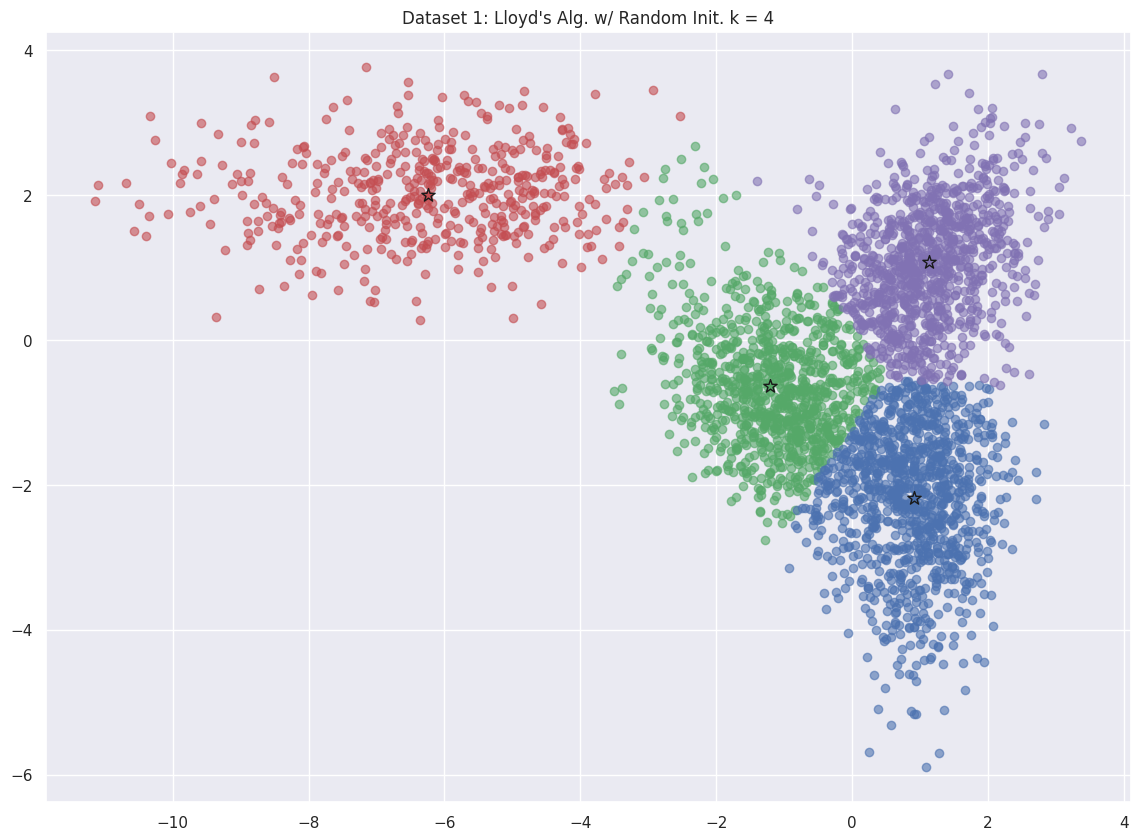

In [137]:
# Experiment 1: Visualisation

k = 4
trials = 10
min_cost = np.inf
i = 0
C = None

for _ in range(trials):
    i_, C_ = lloyd(dataset_1, k, init_random)
    cost = total_cost(C_)
    if cost < min_cost:
        i = i_
        min_cost = cost
        C = C_

sns.set(style="darkgrid")
plt.figure(figsize=(14, 10))

print('Number of iterations: {}'.format(i))
print(f"Cost: {total_cost(C):.2f}")

# Plot the clusters
colours = ['r', 'g', 'b', 'm']
i = 0
for cluster in (C):
    x = [p[0] for p in cluster.data]
    y = [p[1] for p in cluster.data]
    plt.scatter(x, y, c=colours[i], zorder=1, alpha=0.6)  # Add alpha for transparency
    plt.scatter(cluster.centre[0], cluster.centre[1], marker='*', c=colours[i], edgecolors='k', s=100, zorder=2)  # Larger center markers with edge color
    i += 1
plt.title("Dataset 1: Lloyd's Alg. w/ Random Init. k = 4")
plt.show()


-----

k     cost       iterations
2     13563.45   4         
3     8195.58    13        
4     5121.20    6         
5     4238.09    9         
6     3518.22    11        
7     3068.19    18        
8     2609.97    12        
9     2338.28    25        
10    2157.11    9         


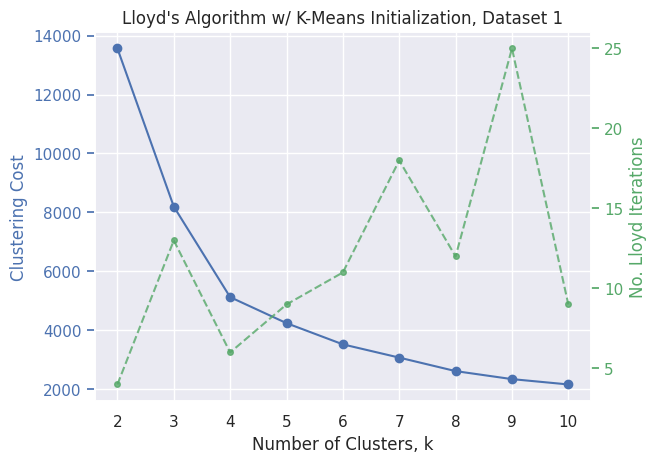

In [48]:
# Experiment 2: Lloyd's Algorithm with K-Means++ Initialization, Dataset 1

k_values = [k for k in range(2, 11)]
num_trials = 10
costs = []
iterations = []

print(f"{'k':<5} {'cost':<10} {'iterations':<10}")
for k in k_values:
    min_cost = np.inf
    C = None
    steps = 0
    for _ in range(num_trials):
        steps_, C_ = lloyd(dataset_1, k, init_kmeans)
        cost = total_cost(C_)
        if cost < min_cost:
            steps = steps_
            min_cost = cost
            C = C_
    # At this point we have the best clustering for this k
    print(f"{k:<5} {min_cost:<10.2f} {steps:<10}")
    iterations.append(steps)
    costs.append(min_cost)

# Plot the cost as a function of k
fig, ax1 = plt.subplots()
plt.title('Lloyd\'s Algorithm w/ K-Means Initialization, Dataset 1')

ax1.plot(k_values, costs, marker='o', linestyle='-', markersize=6)
ax1.set_xlabel('Number of Clusters, k')
ax1.set_ylabel('Clustering Cost', color='b')
ax1.tick_params('y', colors='b', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(k_values, iterations, marker='o', linestyle='--', markersize=4, color='g', alpha=0.8)
ax2.set_ylabel('No. Lloyd Iterations', color='g')
ax2.tick_params('y', colors='g', labelcolor='g')
ax2.grid(False)

plt.show()

The results again apear to show an elbow at k=4. The cost of the clustering at k=4
appears to be the same in both the uniform random initialization and the k-means++
initialization.

Number of iterations: 8
Cost: 3659.68


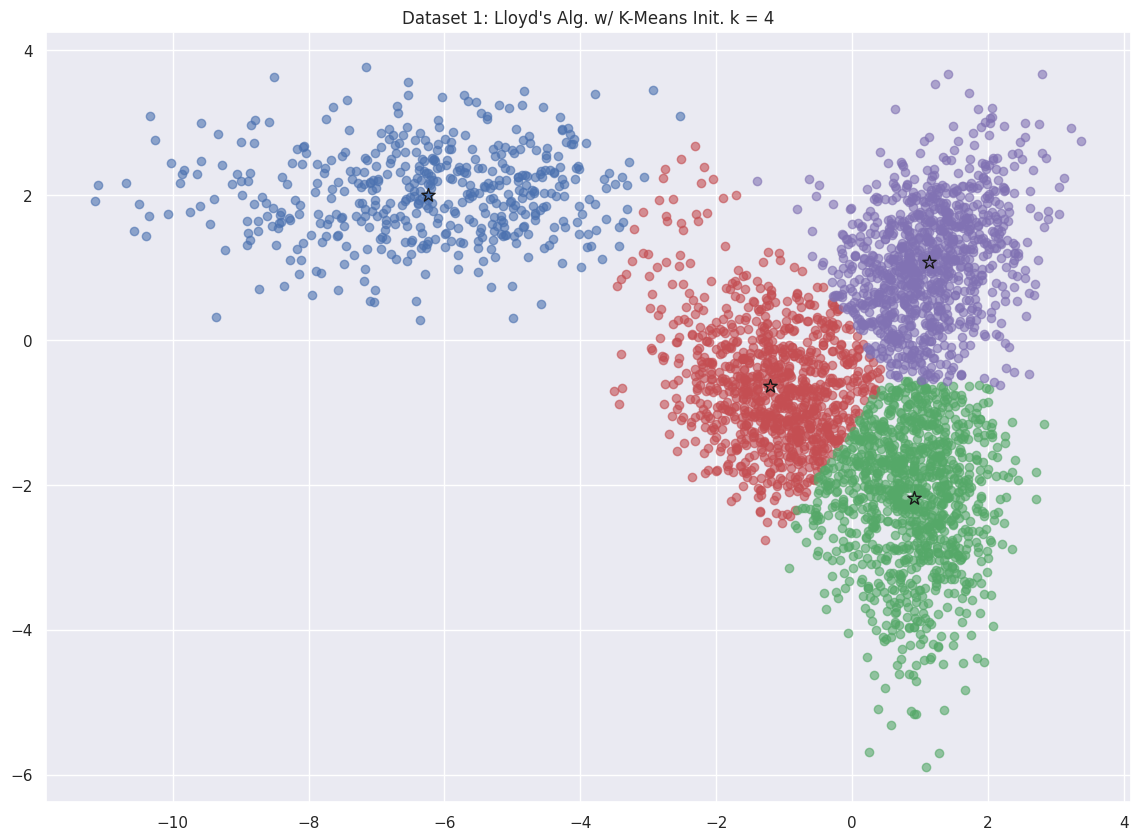

In [136]:
# Expermient 2 Visualisation:

k = 4
trials = 10
min_cost = np.inf
i = 0
C = None

for _ in range(trials):
    i_, C_ = lloyd(dataset_1, k, init_random)
    cost = total_cost(C_)
    if cost < min_cost:
        i = i_
        min_cost = cost
        C = C_

sns.set(style="darkgrid")
plt.figure(figsize=(14, 10))

print('Number of iterations: {}'.format(i))
print(f"Cost: {total_cost(C):.2f}")

# Plot the clusters
colours = ['r', 'g', 'b', 'm']
i  = 0
for cluster in C:
    x = [p[0] for p in cluster.data]
    y = [p[1] for p in cluster.data]
    plt.scatter(x, y, c=colours[i], zorder=1, alpha=0.6)
    plt.scatter(cluster.centre[0], cluster.centre[1], marker='*', c=colours[i], edgecolors='k', s=100, zorder=2)
    i += 1
plt.title("Dataset 1: Lloyd's Alg. w/ K-Means Init. k = 4")
plt.show()

---

k     cost          iterations
2     975123.79     5         
3     743030.41     10        
4     622709.91     27        
5     540006.62     8         
6     467123.50     12        
7     418984.01     11        
8     376427.99     14        
9     352728.19     13        
10    335081.05     12        


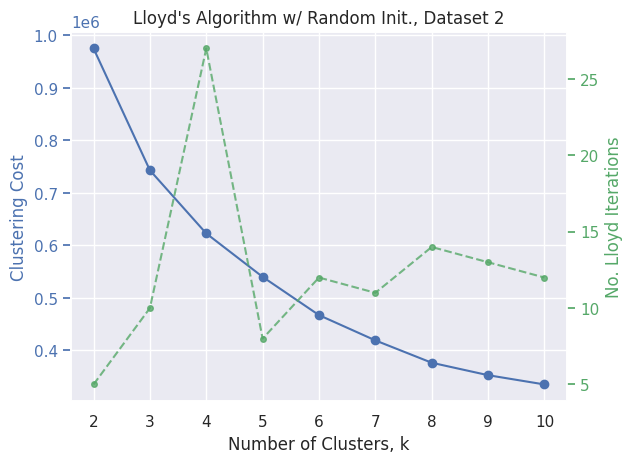

In [36]:
# Experiment 3: Lloyd's Algorithm with Random Initialization, Dataset 2

k_values = [k for k in range(2, 11)]
num_trials = 10
costs = []
iterations = []

print(f"{'k':<5} {'cost':<13} {'iterations':<10}")

for k in k_values:
    min_cost = np.inf
    C = None
    steps = 0
    for _ in range(num_trials):
        steps_, C_ = lloyd(dataset_2, k, init_random)
        cost = total_cost(C_)
        if cost < min_cost:
            steps = steps_
            min_cost = cost
            C = C_
    # At this point we have the best clustering for this k
    print(f"{k:<5} {min_cost:<13.2f} {steps:<10}")
    iterations.append(steps)
    costs.append(min_cost)

fig, ax1 = plt.subplots()
plt.title('Lloyd\'s Algorithm w/ Random Init., Dataset 2')

ax1.plot(k_values, costs, marker='o', linestyle='-', markersize=6)
ax1.set_xlabel('Number of Clusters, k')
ax1.set_ylabel('Clustering Cost', color='b')
ax1.tick_params('y', colors='b', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(k_values, iterations, marker='o', linestyle='--', markersize=4, color='g', alpha=0.8)
ax2.set_ylabel('No. Lloyd Iterations', color='g')
ax2.tick_params('y', colors='g', labelcolor='g')
ax2.grid(False)

plt.show()

Looking at the data, the intuitive answer is that there are 2 spiral clusters. 
However, it is not easy to formally reach that conclusion. Even applying the 
elbow method to the results above, it is difficult to make a confident delcaration
about the number of clusters. The elbow method is not very useful in this case.

The previously observed trend of the number of required iterations sharply increasing
at the elbow does not appear to be present in this case. However, there are two
sharp increases  in the number of iterations required to compute a clustering after
k = 3 and k = 8.

We should expect that Lloyd's algorithm does not perform well on this dataset, 
as it has an interlocking spiral shape, the clusters are not globular. The lack
of a clear elbow in the cost function also supports the notion that Lloyd's algorithm
is not well suited to this dataset.

Number of iterations: 4
Cost: 111316.66


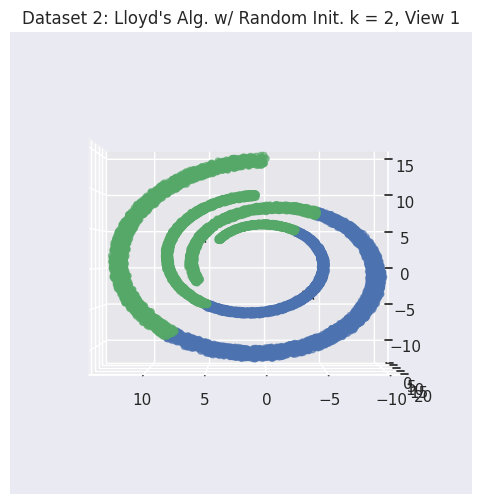

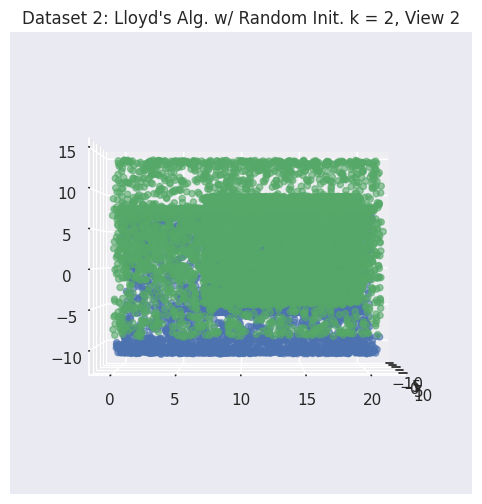

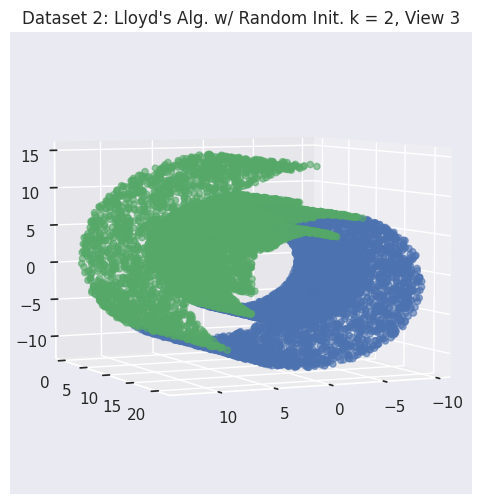

In [118]:
# Experiment 3 Visualisation:

# Use k = 2 because that is my bias

k = 2
trials = 10

min_cost = np.inf
i = 0
C = None

for _ in range(trials):
    i_, C_ = lloyd(dataset_2, k, init_random)
    cost = total_cost(C_)
    if cost < min_cost:
        i = i_
        min_cost = cost
        C = C_

sns.set(style="darkgrid")
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

print('Number of iterations: {}'.format(i))
print(f"Cost: {total_cost(C):.2f}")

colours = ['g', 'b']
i  = 0
for cluster in C:
    x = [p[0] for p in cluster.data]
    y = [p[1] for p in cluster.data]
    z = [p[2] for p in cluster.data]
    ax.scatter(x, y, z, c=colours[i], zorder=1, alpha=0.6)
    ax.scatter(cluster.centre[0], cluster.centre[1], cluster.centre[2], marker='*', c=colours[i], edgecolors='k', s=100, zorder=2)
    i += 1
# Set viewing angle
ax.view_init(elev=0, azim=90)
plt.title("Dataset 2: Lloyd's Alg. w/ Random Init. k = 2, View 1")
plt.show()

fig2 = plt.figure(figsize=(8, 6))
ax = fig2.add_subplot(111, projection='3d')

i  = 0
for cluster in C:
    x = [p[0] for p in cluster.data]
    y = [p[1] for p in cluster.data]
    z = [p[2] for p in cluster.data]
    ax.scatter(x, y, z, c=colours[i], zorder=1, alpha=0.6)
    ax.scatter(cluster.centre[0], cluster.centre[1], cluster.centre[2], marker='*', c=colours[i], edgecolors='k', s=100, zorder=2)
    i += 1
# Set viewing angle
ax.view_init(elev=0, azim=0)
plt.title("Dataset 2: Lloyd's Alg. w/ Random Init. k = 2, View 2")
plt.show()

fig3 = plt.figure(figsize=(8, 6))
ax = fig3.add_subplot(111, projection='3d')

i  = 0
for cluster in C:
    x = [p[0] for p in cluster.data]
    y = [p[1] for p in cluster.data]
    z = [p[2] for p in cluster.data]
    ax.scatter(x, y, z, c=colours[i], zorder=1, alpha=0.6)
    ax.scatter(cluster.centre[0], cluster.centre[1], cluster.centre[2], marker='*', c=colours[i], edgecolors='k', s=100, zorder=2)
    i += 1
# Set viewing angle
ax.view_init(elev=5, azim=65)
plt.title("Dataset 2: Lloyd's Alg. w/ Random Init. k = 2, View 3")
plt.show()


Number of iterations: 8
Cost: 96313.42


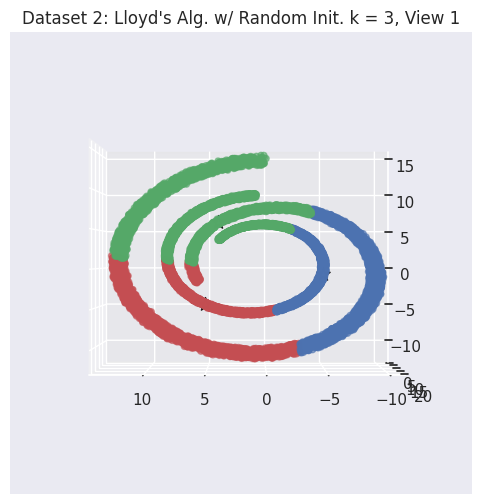

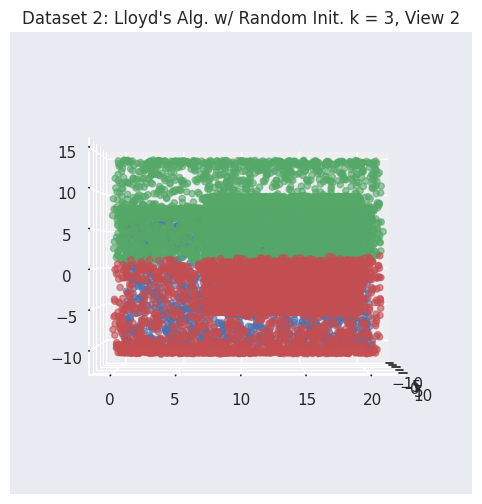

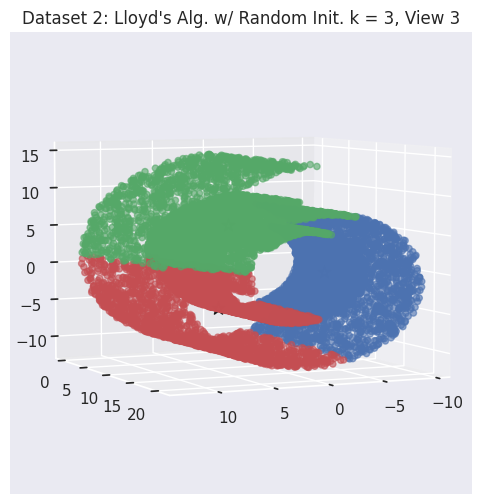

In [117]:
# Experiment 3 Visualisation:

# Now use k=3, as suggested by the elbow method

k = 3
trials = 10

min_cost = np.inf
i = 0
C = None

for _ in range(trials):
    i_, C_ = lloyd(dataset_2, k, init_random)
    cost = total_cost(C_)
    if cost < min_cost:
        i = i_
        min_cost = cost
        C = C_

sns.set(style="darkgrid")
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

print('Number of iterations: {}'.format(i))
print(f"Cost: {total_cost(C):.2f}")

colours = ['g', 'b', 'r']
i  = 0
for cluster in C:
    x = [p[0] for p in cluster.data]
    y = [p[1] for p in cluster.data]
    z = [p[2] for p in cluster.data]
    ax.scatter(x, y, z, c=colours[i], zorder=1, alpha=0.6)
    ax.scatter(cluster.centre[0], cluster.centre[1], cluster.centre[2], marker='*', c=colours[i], edgecolors='k', s=100, zorder=2)
    i += 1
# Set viewing angle
ax.view_init(elev=0, azim=90)
plt.title("Dataset 2: Lloyd's Alg. w/ Random Init. k = 3, View 1")
plt.show()

fig2 = plt.figure(figsize=(8, 6))
ax = fig2.add_subplot(111, projection='3d')

i  = 0
for cluster in C:
    x = [p[0] for p in cluster.data]
    y = [p[1] for p in cluster.data]
    z = [p[2] for p in cluster.data]
    ax.scatter(x, y, z, c=colours[i], zorder=1, alpha=0.6)
    ax.scatter(cluster.centre[0], cluster.centre[1], cluster.centre[2], marker='*', c=colours[i], edgecolors='k', s=100, zorder=2)
    i += 1
# Set viewing angle
ax.view_init(elev=0, azim=0)
plt.title("Dataset 2: Lloyd's Alg. w/ Random Init. k = 3, View 2")
plt.show()

fig3 = plt.figure(figsize=(8, 6))
ax = fig3.add_subplot(111, projection='3d')

i  = 0
for cluster in C:
    x = [p[0] for p in cluster.data]
    y = [p[1] for p in cluster.data]
    z = [p[2] for p in cluster.data]
    ax.scatter(x, y, z, c=colours[i], zorder=1, alpha=0.6)
    ax.scatter(cluster.centre[0], cluster.centre[1], cluster.centre[2], marker='*', c=colours[i], edgecolors='k', s=100, zorder=2)
    i += 1
# Set viewing angle
ax.view_init(elev=5, azim=65)
plt.title("Dataset 2: Lloyd's Alg. w/ Random Init. k = 3, View 3")
plt.show()


---

k     cost          iterations
2     975534.16     5         
3     742593.55     7         
4     622082.30     6         
5     539709.98     14        
6     468925.70     17        
7     418777.01     18        
8     376153.90     10        
9     352849.56     11        
10    325895.50     10        


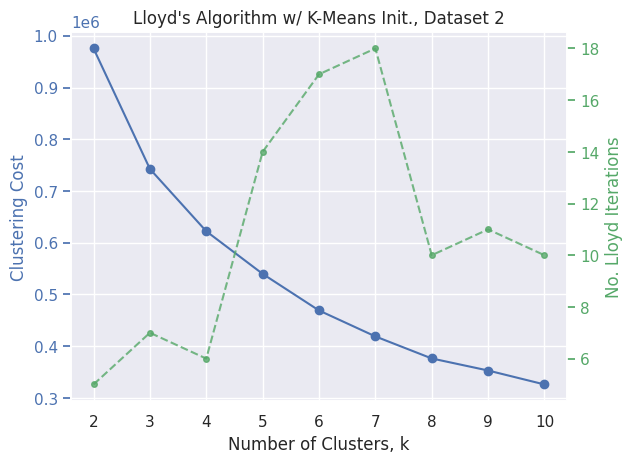

In [37]:
# Experiment 4: Lloyd's Algorithm with K-Means Initialization, Dataset 2

k_values = [k for k in range(2, 11)]
num_trials = 10
costs = []
iterations = []

print(f"{'k':<5} {'cost':<13} {'iterations':<10}")

for k in k_values:
    min_cost = np.inf
    C = None
    steps = 0
    for _ in range(num_trials):
        steps_, C_ = lloyd(dataset_2, k, init_kmeans)
        cost = total_cost(C_)
        if cost < min_cost:
            steps = steps_
            min_cost = cost
            C = C_
    # At this point we have the best clustering for this k
    print(f"{k:<5} {min_cost:<13.2f} {steps:<10}")
    iterations.append(steps)
    costs.append(min_cost)

fig, ax1 = plt.subplots()
plt.title('Lloyd\'s Algorithm w/ K-Means Init., Dataset 2')

ax1.plot(k_values, costs, marker='o', linestyle='-', markersize=6)
ax1.set_xlabel('Number of Clusters, k')
ax1.set_ylabel('Clustering Cost', color='b')
ax1.tick_params('y', colors='b', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(k_values, iterations, marker='o', linestyle='--', markersize=4, color='g', alpha=0.8)
ax2.set_ylabel('No. Lloyd Iterations', color='g')
ax2.tick_params('y', colors='g', labelcolor='g')
ax2.grid(False)

plt.show()

It is again hard to determine the proper number of clusters in this dataset from 
the cost graph above, suggesting perhaps that Lloyd's algorithm is not well suited
to this dataset. The elbow method does not appear to be useful in this case. 

The curve shows a steady decrease in the cost of the clustering as the number of
clusters increases. With a smooth decreease in the rate of decrease.

Knowing that the proper clustering is likely 2, it is possible to argue from
the graphed indicators that the elbow is at k=2, or k=3. However, the elbow
method is not very useful in this case.

Number of iterations: 5
Cost: 975534.16


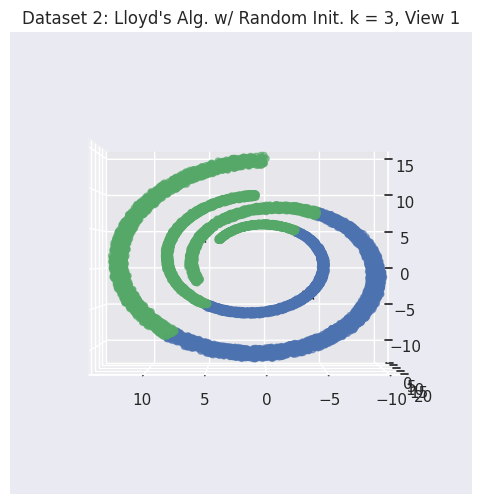

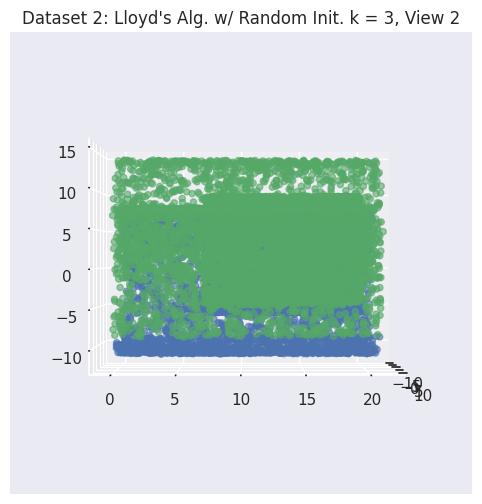

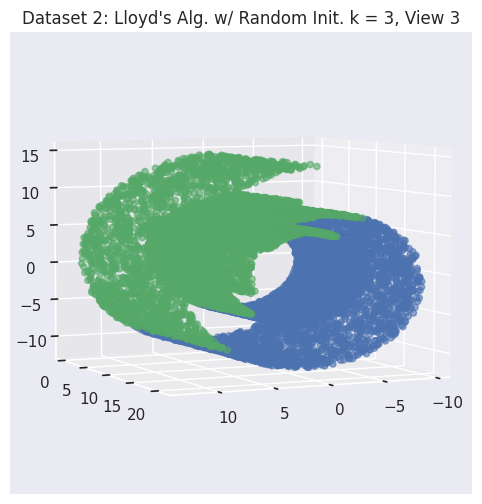

In [38]:
# Experiment 4 Visualisation:

k = 2
trials = 10

min_cost = np.inf
i = 0
C = None

for _ in range(trials):
    i_, C_ = lloyd(dataset_2, k, init_kmeans)
    cost = total_cost(C_)
    if cost < min_cost:
        i = i_
        min_cost = cost
        C = C_

sns.set(style="darkgrid")
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

print('Number of iterations: {}'.format(i))
print(f"Cost: {total_cost(C):.2f}")

colours = ['g', 'b', 'r']
i  = 0
for cluster in C:
    x = [p[0] for p in cluster.data]
    y = [p[1] for p in cluster.data]
    z = [p[2] for p in cluster.data]
    ax.scatter(x, y, z, c=colours[i], zorder=1, alpha=0.6)
    ax.scatter(cluster.centre[0], cluster.centre[1], cluster.centre[2], marker='*', c=colours[i], edgecolors='k', s=100, zorder=2)
    i += 1
# Set viewing angle
ax.view_init(elev=0, azim=90)
plt.title("Dataset 2: Lloyd's Alg. w/ Random Init. k = 3, View 1")
plt.show()

fig2 = plt.figure(figsize=(8, 6))
ax = fig2.add_subplot(111, projection='3d')

i  = 0
for cluster in C:
    x = [p[0] for p in cluster.data]
    y = [p[1] for p in cluster.data]
    z = [p[2] for p in cluster.data]
    ax.scatter(x, y, z, c=colours[i], zorder=1, alpha=0.6)
    ax.scatter(cluster.centre[0], cluster.centre[1], cluster.centre[2], marker='*', c=colours[i], edgecolors='k', s=100, zorder=2)
    i += 1
# Set viewing angle
ax.view_init(elev=0, azim=0)
plt.title("Dataset 2: Lloyd's Alg. w/ Random Init. k = 3, View 2")
plt.show()

fig3 = plt.figure(figsize=(8, 6))
ax = fig3.add_subplot(111, projection='3d')

i  = 0
for cluster in C:
    x = [p[0] for p in cluster.data]
    y = [p[1] for p in cluster.data]
    z = [p[2] for p in cluster.data]
    ax.scatter(x, y, z, c=colours[i], zorder=1, alpha=0.6)
    ax.scatter(cluster.centre[0], cluster.centre[1], cluster.centre[2], marker='*', c=colours[i], edgecolors='k', s=100, zorder=2)
    i += 1
# Set viewing angle
ax.view_init(elev=5, azim=65)
plt.title("Dataset 2: Lloyd's Alg. w/ Random Init. k = 3, View 3")
plt.show()


---

## Part 2: Hierarchical Agglomerative Clustering

- Use the Eucilidian distance as the distance metric
- Use both single-linkage and average-linkage clustering
- Determine what final clustering to pick for the dataset, and explain
    why you chose that clustering.
- Explain reasoning for where to make a cut in the dendrogram
- Use scipy.cluster.hierarchy dendrogram to visualize the dendrogram
- Use truncate_mode='lastp'


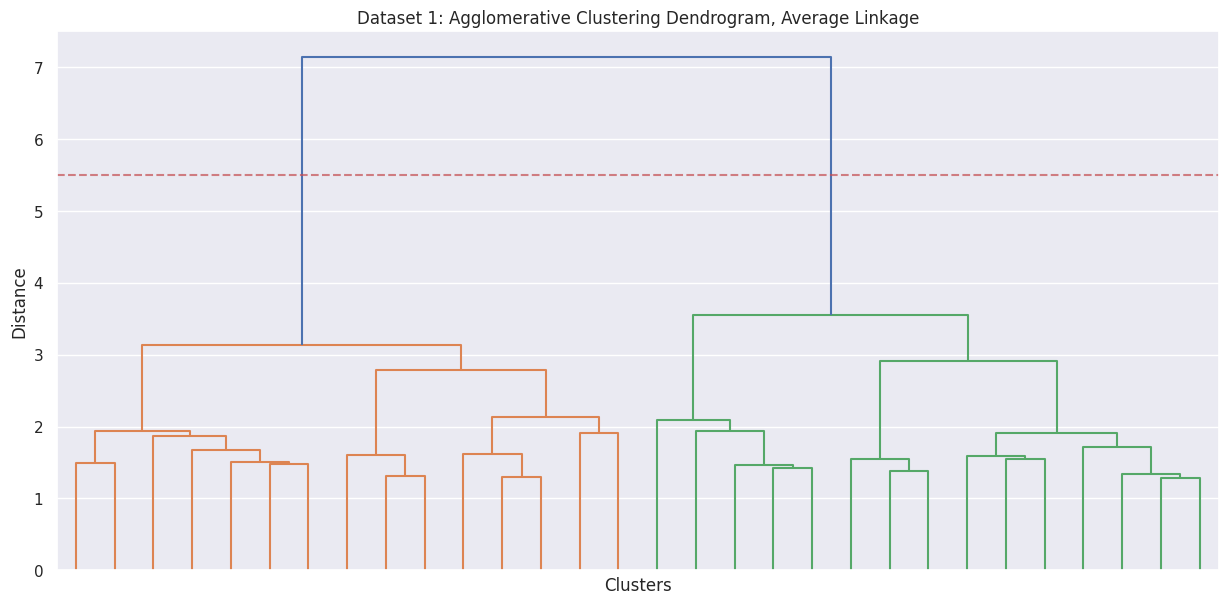

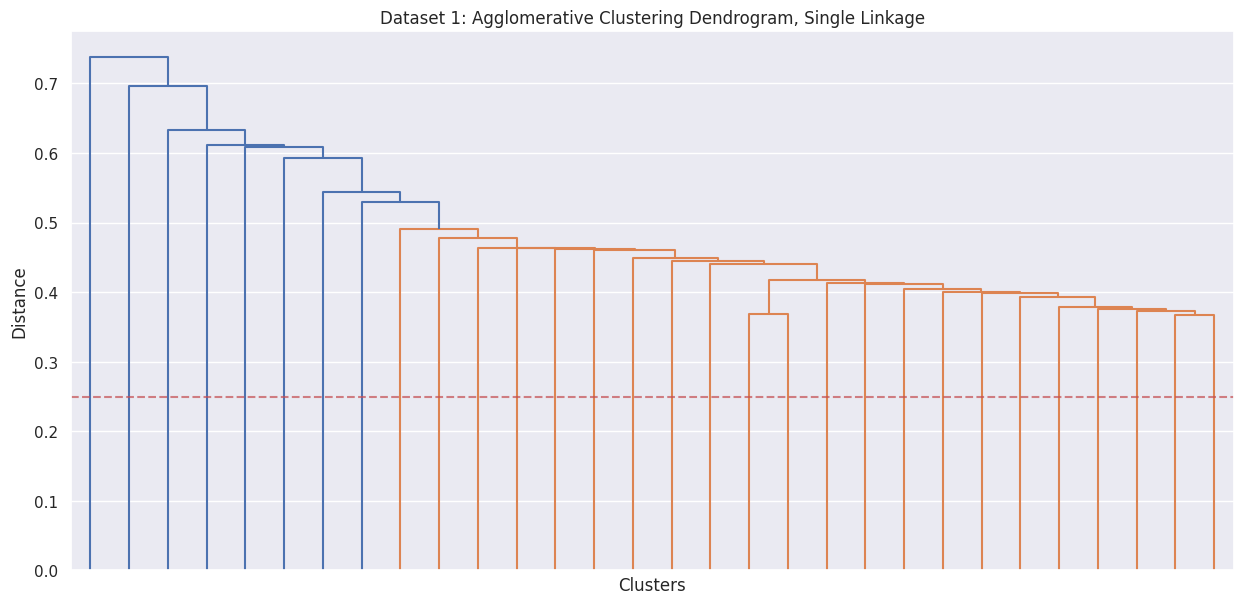

In [25]:
# Dendrograms 1: 2D

from scipy.cluster.hierarchy import dendrogram, linkage
sns.set(style="darkgrid")

linkage_matrix = linkage(dataset_1, method='average', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(15, 7))
dendrogram(linkage_matrix, no_labels=True, truncate_mode='lastp', orientation='top')
plt.xlabel('Clusters')
plt.ylabel('Distance')
plt.title('Dataset 1: Agglomerative Clustering Dendrogram, Average Linkage')
plt.axhline(y=5.5, color='r', linestyle='--', alpha=0.7)
plt.show()

linkage_matrix = linkage(dataset_1, method='single', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(15, 7))
dendrogram(linkage_matrix, no_labels=True, truncate_mode='lastp', orientation='top')
plt.xlabel('Clusters')
plt.ylabel('Distance')
plt.title('Dataset 1: Agglomerative Clustering Dendrogram, Single Linkage')
plt.axhline(y=0.25, color='r', linestyle='--', alpha=0.7)
plt.show()

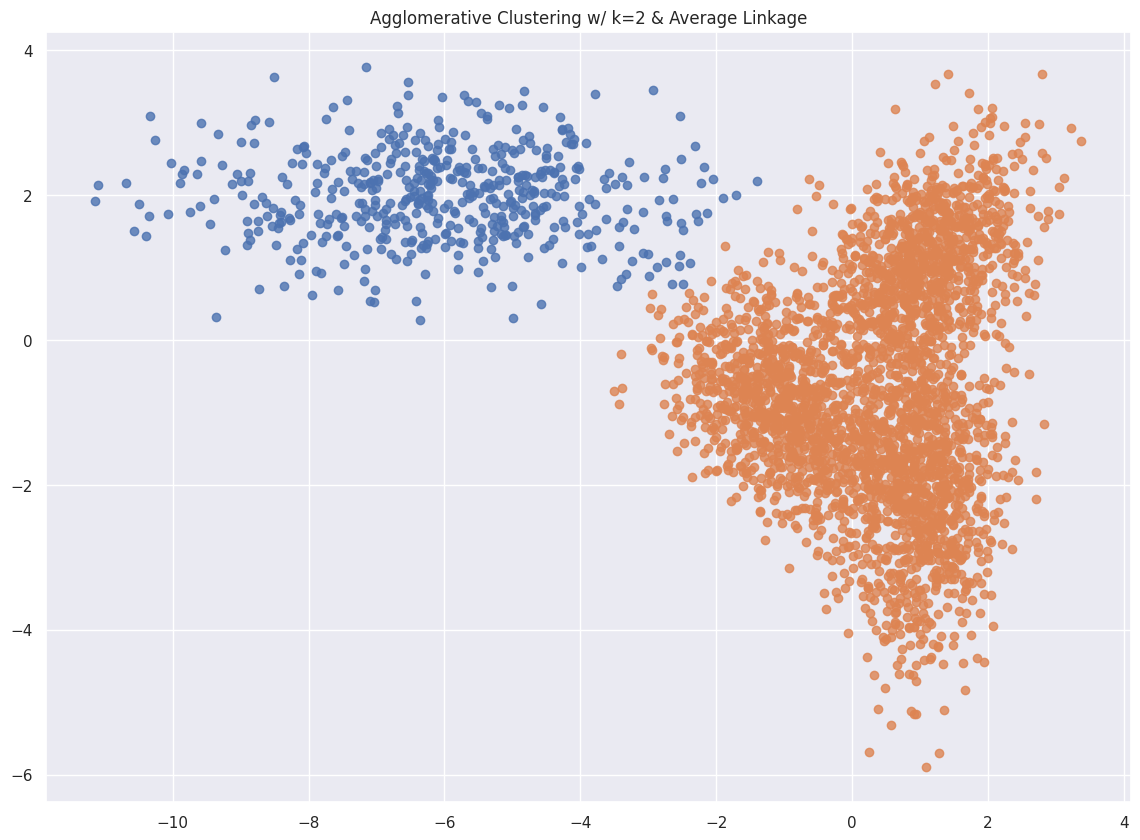

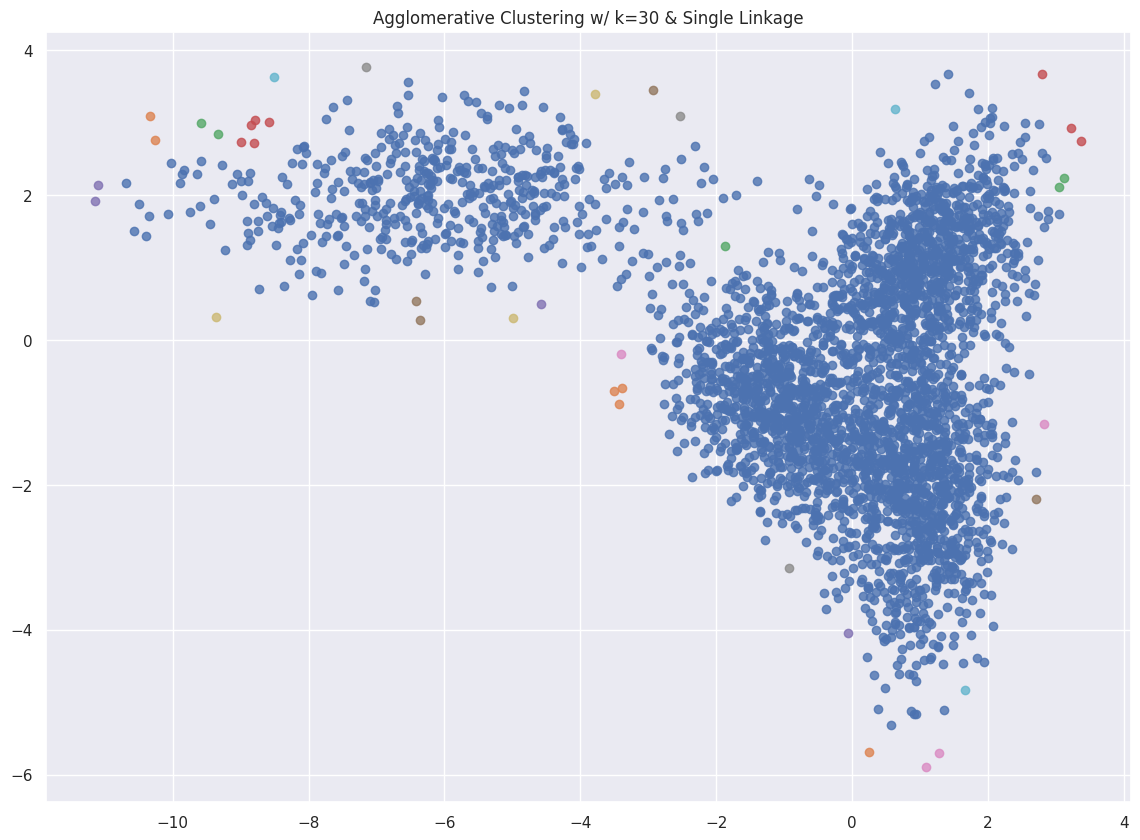

In [26]:
# Agglomerative Clustering 1: 2D

from sklearn.cluster import AgglomerativeClustering as AC
sns.set(style="darkgrid")

n_clusters = 2

model = AC(n_clusters=n_clusters, linkage='average')
model.fit(dataset_1)


# Generate or import your data
# Fit the AgglomerativeClustering model with N clusters

# Create a dictionary to store clusters
clusters = {i: [] for i in range(n_clusters)}

# Fill the clusters dictionary with data points
for i in range(len(dataset_1)):
    label = model.labels_[i]
    x, y = dataset_1[i]
    clusters[label].append((x, y))

# Plot the clusters
plt.figure(figsize=(14, 10))
# colors = plt.cm.get_cmap('viridis', n_clusters)

for i, cluster_data in clusters.items():
    x = [point[0] for point in cluster_data]
    y = [point[1] for point in cluster_data]
    plt.scatter(x, y, alpha=0.8, label=f'Cluster {i}')

plt.title(f'Agglomerative Clustering w/ k={2} & Average Linkage')
plt.show()

n_clusters = 30

model = AC(n_clusters=n_clusters, linkage='single')
model.fit(dataset_1)

# Generate or import your data
# Fit the AgglomerativeClustering model with N clusters

# Create a dictionary to store clusters
clusters = {i: [] for i in range(n_clusters)}

# Fill the clusters dictionary with data points
for i in range(len(dataset_1)):
    label = model.labels_[i]
    x, y = dataset_1[i]
    clusters[label].append((x, y))

# Plot the clusters
plt.figure(figsize=(14, 10))
# colors = plt.cm.get_cmap('viridis', n_clusters)

for i, cluster_data in clusters.items():
    x = [point[0] for point in cluster_data]
    y = [point[1] for point in cluster_data]
    plt.scatter(x, y, alpha=0.8, label=f'Cluster {i}')

plt.title(f'Agglomerative Clustering w/ k={30} & Single Linkage')
plt.show()

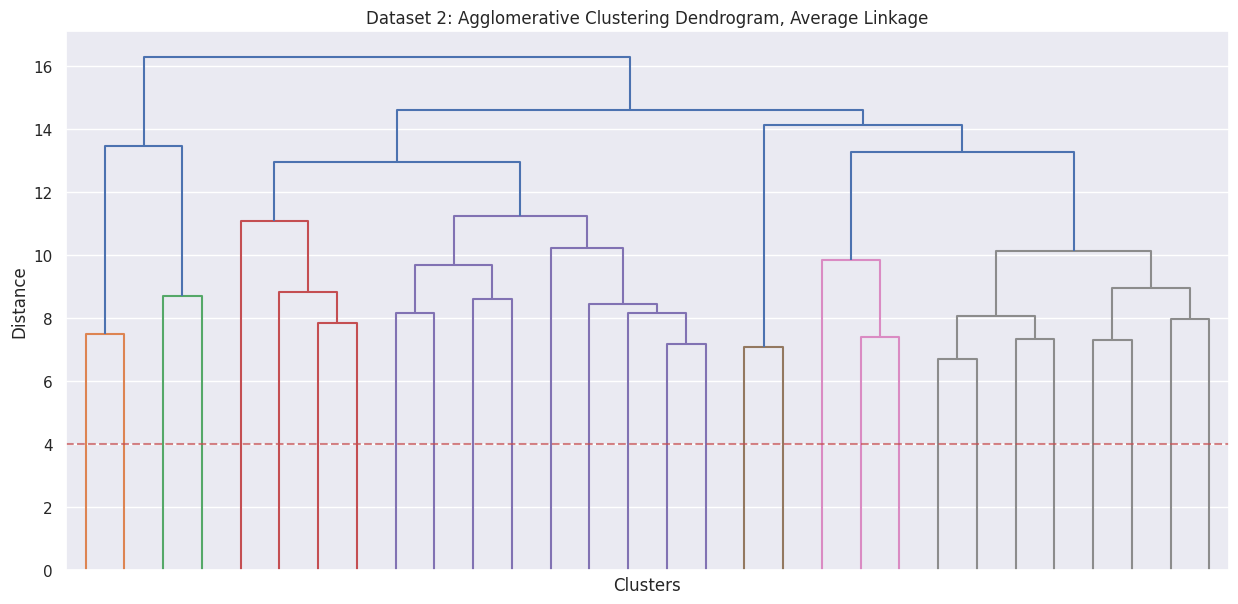

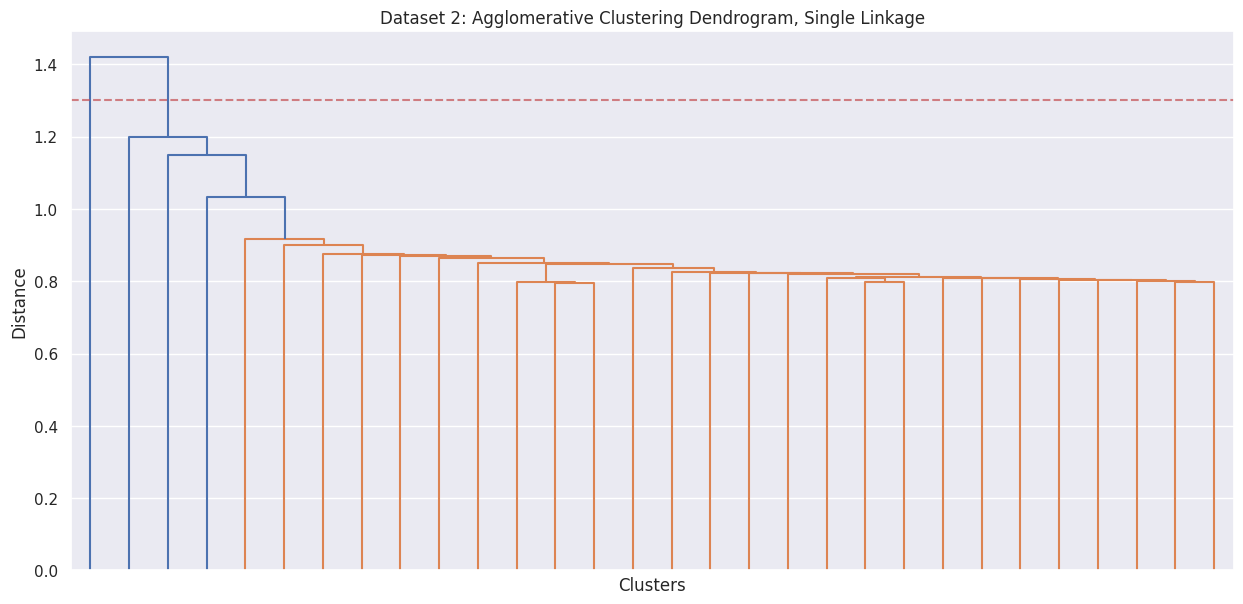

In [27]:
# Dendrograms 2: 3D
sns.set(style="darkgrid")

from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(dataset_2, method='average', metric='euclidean') # optimal_ordering=True

# Plot the dendrogram
plt.figure(figsize=(15, 7))
dendrogram(linkage_matrix, no_labels=True, truncate_mode='lastp', orientation='top')
plt.xlabel('Clusters')
plt.ylabel('Distance')
plt.title('Dataset 2: Agglomerative Clustering Dendrogram, Average Linkage')
plt.axhline(y=4, color='r', linestyle='--', alpha=0.7)
plt.show()

linkage_matrix = linkage(dataset_2, method='single', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(15, 7))
dendrogram(linkage_matrix, no_labels=True, truncate_mode='lastp', orientation='top')
plt.xlabel('Clusters')
plt.ylabel('Distance')
plt.title('Dataset 2: Agglomerative Clustering Dendrogram, Single Linkage')
plt.axhline(y=1.3, color='r', linestyle='--', alpha=0.7)
plt.show()

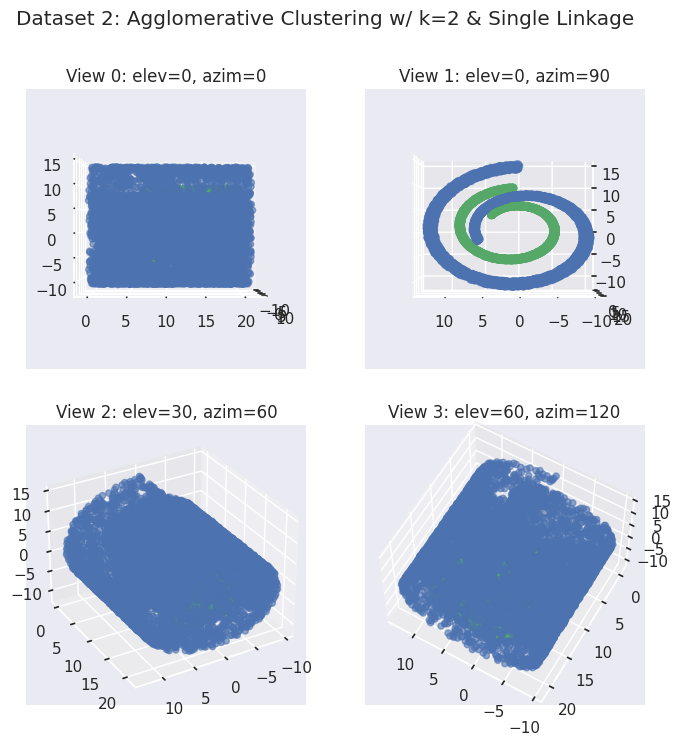

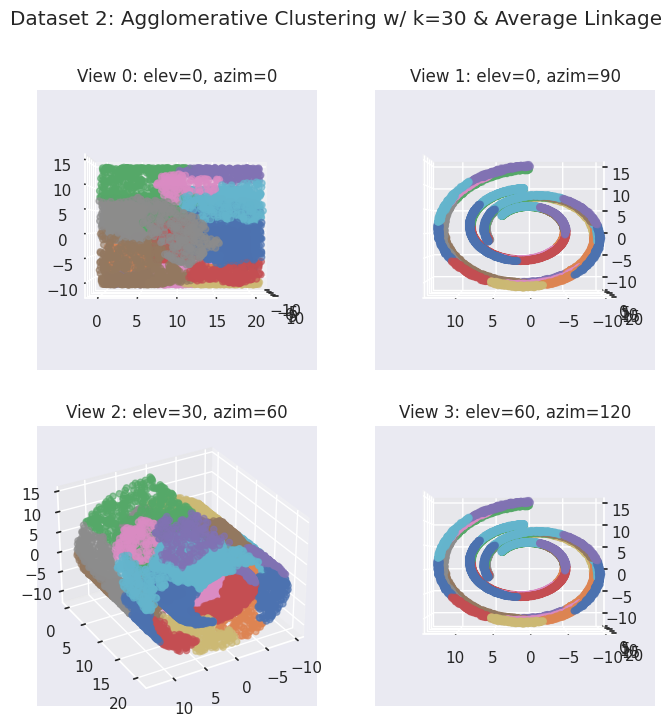

In [28]:
# Agglomerative Clustering 2: 3D
sns.set(style="darkgrid")

n_clusters = 2

model = AC(n_clusters=n_clusters, linkage='single')
model.fit(dataset_2)

# Generate or import your data
# Fit the AgglomerativeClustering model with N clusters

# Create a dictionary to store clusters
clusters = {i: [] for i in range(n_clusters)}
colours = ['b', 'g']

# Fill the clusters dictionary with data points
for i in range(len(dataset_2)):
    label = model.labels_[i]
    x, y, z = dataset_2[i]
    clusters[label].append((x, y, z))

view_angles = [
    (0, 0),
    (0, 90),
    (30, 60),
    (60, 120)
]

# Plot the clusters
fig = plt.figure(figsize=(8, 8))
for i, (elev, azim) in enumerate(view_angles):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    for j, cluster_data in clusters.items():
        x = [point[0] for point in cluster_data]
        y = [point[1] for point in cluster_data]
        z = [point[2] for point in cluster_data]
        ax.scatter(x, y, z, zorder=1, alpha=0.6, c=colours[j], label=f'Cluster {j}')
    ax.view_init(elev=elev, azim=azim)
    plt.title(f'View {i}: elev={elev}, azim={azim}')

plt.suptitle(f'Dataset 2: Agglomerative Clustering w/ k={2} & Single Linkage')
plt.show()

n_clusters = 30

model = AC(n_clusters=n_clusters, linkage='average')
model.fit(dataset_2)

# Generate or import your data
# Fit the AgglomerativeClustering model with N clusters

# Create a dictionary to store clusters
clusters = {i: [] for i in range(n_clusters)}
colours = ['b', 'g']

# Fill the clusters dictionary with data points
for i in range(len(dataset_2)):
    label = model.labels_[i]
    x, y, z = dataset_2[i]
    clusters[label].append((x, y, z))

# Plot the clusters
fig = plt.figure(figsize=(8, 8))
for i, (elev, azim) in enumerate(view_angles):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    for j, cluster_data in clusters.items():
        x = [point[0] for point in cluster_data]
        y = [point[1] for point in cluster_data]
        z = [point[2] for point in cluster_data]
        ax.scatter(x, y, z, zorder=1, alpha=0.6, label=f'Cluster {j}')
    ax.view_init(elev=elev, azim=azim)
    plt.title(f'View {i}: elev={elev}, azim={azim}')

ax.view_init(elev=0, azim=90)
plt.suptitle(f'Dataset 2: Agglomerative Clustering w/ k={30} & Average Linkage')
plt.show()